In [29]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
from torchvision.utils import make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from collections import Counter
import seaborn as sns
import random

## Preprocessing

In [3]:
import os
from PIL import Image

def split_images_in_folder(input_folder, satellite_folder, map_folder):
    # Ensure the output directories exist
    os.makedirs(satellite_folder, exist_ok=True)
    os.makedirs(map_folder, exist_ok=True)
    
    # Initialize counters for satellite and map images
    satellite_counter = 0
    map_counter = 0
    
    # Loop through all files in the input folder
    for filename in sorted(os.listdir(input_folder)):  # Sorted to ensure consistent order
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(input_folder, filename)
            
            # Open the image
            image = Image.open(image_path)
            width, height = image.size
            
            # Split the image into left (satellite) and right (map)
            left_half = image.crop((0, 0, width // 2, height))
            right_half = image.crop((width // 2, 0, width, height))
            
            # Create filenames with ascending numbers
            satellite_output_path = os.path.join(satellite_folder, f"satellite_{satellite_counter}.jpg")
            map_output_path = os.path.join(map_folder, f"map_{map_counter}.jpg")
            
            # Save the satellite and map images
            left_half.save(satellite_output_path)
            right_half.save(map_output_path)
            
            # Increment counters
            satellite_counter += 1
            map_counter += 1

    print("Processing complete! Images saved with ascending numerical filenames.")

# Example usage:
input_folder = 'D:\\Datasets\\Detailed map from Aerial Images\\datasets\\raw_data\\'  # Replace with the path to your input folder
satellite_folder = 'D:\\Datasets\\Detailed map from Aerial Images\\datasets\\satellite\\'  # Replace with the path to satellite output folder
map_folder = 'D:\\Datasets\\Detailed map from Aerial Images\\datasets\\maps'  # Replace with the path to map output folder

split_images_in_folder(input_folder, satellite_folder, map_folder)


Processing complete! Images saved with ascending numerical filenames.


## Dataset Preparation

In [4]:
class SatMapDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.satellite_images = sorted(os.listdir(os.path.join(root_dir, "satellite")))
        self.map_images = sorted(os.listdir(os.path.join(root_dir, "maps")))

    def __len__(self):
        return len(self.satellite_images)

    def __getitem__(self, idx):
        satellite_path = os.path.join(self.root_dir, "satellite", self.satellite_images[idx])
        map_path = os.path.join(self.root_dir, "maps", self.map_images[idx])
        satellite_image = Image.open(satellite_path).convert("RGB")
        map_image = Image.open(map_path)  # Convert map to grayscale

        if self.transform:
            satellite_image = self.transform(satellite_image)
            map_image = self.transform(map_image)

        return satellite_image, map_image


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [17]:
dataset = SatMapDataset(root_dir="D:\\Datasets\\Detailed map from Aerial Images\\datasets\\", transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Visualization of dataset


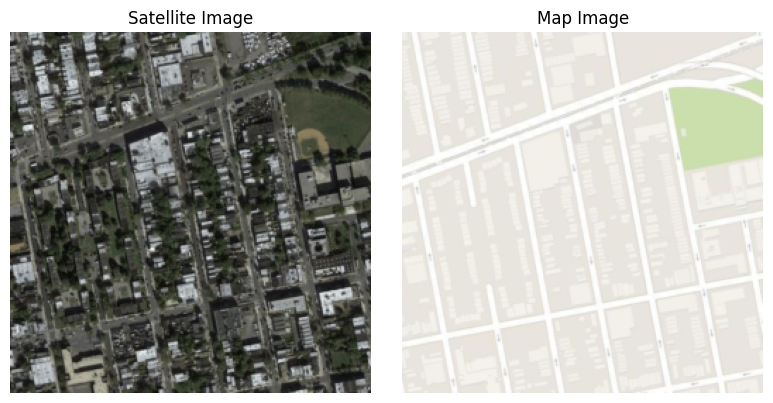

C:\Users\shafq\AppData\Local\Temp\ipykernel_11652\993567537.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=folder_names, y=image_counts, palette="Blues_d")


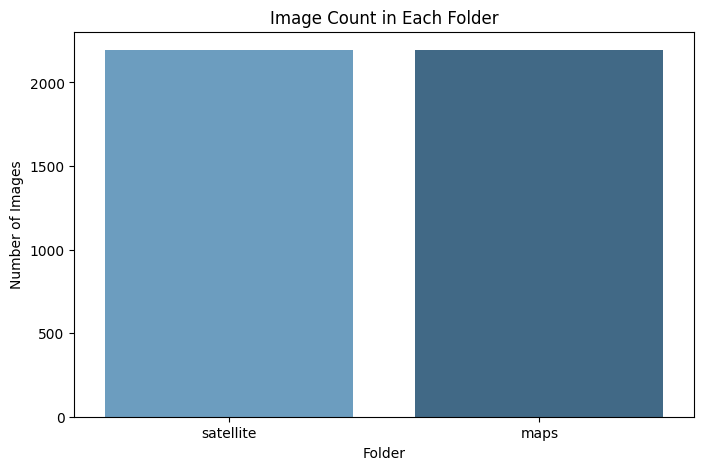

In [25]:
# Visualize a sample from the dataset
def visualize_sample(dataset):
    satellite_image, map_image = dataset[0]  # Take the first sample
    satellite_image = satellite_image.permute(1, 2, 0).numpy()  # Convert to (H, W, C) for visualization
    map_image = map_image.permute(1, 2, 0).numpy()

    # Denormalize images
    satellite_image = (satellite_image * 0.5 + 0.5) * 255
    map_image = (map_image * 0.5 + 0.5) * 255

    # Plot
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(satellite_image.astype('uint8'))
    plt.title("Satellite Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(map_image.astype('uint8'))
    plt.title("Map Image")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def plot_image_distribution(root_dir):
    # Get the count of images in each folder
    folder_names = ["satellite", "maps"]
    image_counts = []

    for folder in folder_names:
        folder_path = os.path.join(root_dir, folder)
        image_counts.append(len(os.listdir(folder_path)))

    # Plot the distribution
    plt.figure(figsize=(8, 5))
    sns.barplot(x=folder_names, y=image_counts, palette="Blues_d")
    plt.title("Image Count in Each Folder")
    plt.xlabel("Folder")
    plt.ylabel("Number of Images")
    plt.show()


# Call functions
root_dir = "D:\\Datasets\\Detailed map from Aerial Images\\datasets\\"
visualize_sample(dataset)
plot_image_distribution(root_dir)

# Spliting the dataset

In [7]:
# Define the split ratio
train_ratio = 0.8  # 80% for training
val_ratio = 0.2    # 20% for validation

# Calculate the lengths for the split
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for both the training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# Model Architecture

In [8]:
class UNetGenerator(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, num_downs=8, ngf=64):
        super(UNetGenerator, self).__init__()
        
        # Construct U-Net generator
        # Add the innermost layer
        unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, innermost=True)
        
        # Add intermediate layers with ngf * 8 filters
        for _ in range(num_downs - 5):
            unet_block = UNetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block)
        
        # Gradually reduce the number of filters
        unet_block = UNetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block)
        unet_block = UNetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block)
        unet_block = UNetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block)
        
        # Add the outermost layer
        self.model = UNetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True)
        
    def forward(self, x):
        return self.model(x)

class UNetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None, submodule=None, outermost=False, innermost=False, use_dropout=False):
        super(UNetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4, stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(outer_nc)
        
        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc, kernel_size=4, stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            
            if use_dropout:
                up += [nn.Dropout(0.5)]
            
            model = down + [submodule] + up
        
        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

In [9]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc=6, ndf=64, n_layers=3):
        """
        A PatchGAN discriminator
        Args:
            input_nc (int): Number of channels in input images. Since we concatenate input and target, input_nc= input_image + target_image channels
            ndf (int): Number of filters in the last conv layer
            n_layers (int): Number of downsampling layers
        """
        super(NLayerDiscriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                nn.BatchNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            nn.BatchNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]
        # Final layer
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]
        
        self.model = nn.Sequential(*sequence)
        
    def forward(self, x):
        return self.model(x)


In [10]:
# Adversarial loss
criterion_GAN = nn.MSELoss()
# L1 loss
criterion_L1 = nn.L1Loss()

In [13]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize generator and discriminator
netG = UNetGenerator().to(device)
netD = NLayerDiscriminator().to(device)

# Initialize weights
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

netG.apply(weights_init_normal)
netD.apply(weights_init_normal)

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))


# Training and Testing without Tuning

Epoch [1/100] - Loss D: 0.1181, Loss G: 7.5662
Epoch [2/100] - Loss D: 0.0980, Loss G: 7.0812
Epoch [3/100] - Loss D: 0.0607, Loss G: 6.9854
Epoch [4/100] - Loss D: 0.0334, Loss G: 6.8637
Epoch [5/100] - Loss D: 0.0412, Loss G: 6.7235
Epoch [6/100] - Loss D: 0.0179, Loss G: 6.7076
Epoch [7/100] - Loss D: 0.0233, Loss G: 6.5575
Epoch [8/100] - Loss D: 0.0638, Loss G: 6.5491
Epoch [9/100] - Loss D: 0.0773, Loss G: 6.3976
Epoch [10/100] - Loss D: 0.0582, Loss G: 6.3837
Epoch [11/100] - Loss D: 0.0926, Loss G: 6.2614
Epoch [12/100] - Loss D: 0.0937, Loss G: 6.3115
Epoch [13/100] - Loss D: 0.0872, Loss G: 6.1259
Epoch [14/100] - Loss D: 0.0922, Loss G: 6.1230
Epoch [15/100] - Loss D: 0.0889, Loss G: 5.9762
Epoch [16/100] - Loss D: 0.0901, Loss G: 5.7576
Epoch [17/100] - Loss D: 0.0928, Loss G: 5.7149
Epoch [18/100] - Loss D: 0.0889, Loss G: 5.5449
Epoch [19/100] - Loss D: 0.0889, Loss G: 5.3901
Epoch [20/100] - Loss D: 0.0946, Loss G: 5.3772
Epoch [21/100] - Loss D: 0.0876, Loss G: 5.2306
E

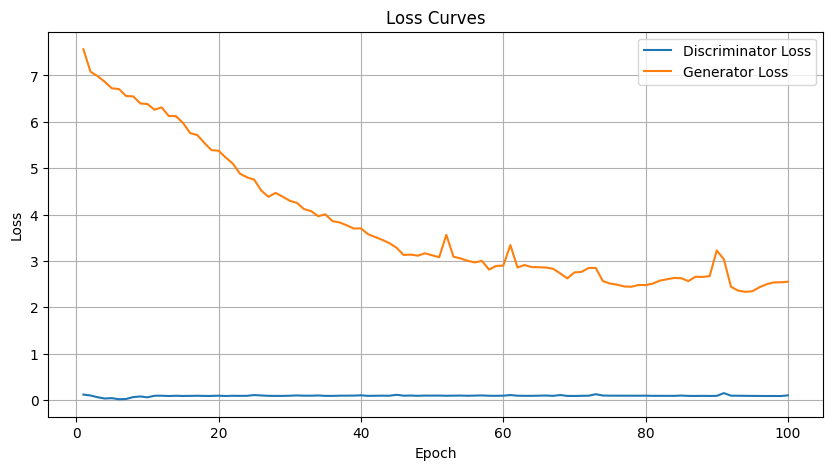

In [55]:
# Training parameters
num_epochs = 100

# Lists to store loss values for plotting
loss_D_list = []
loss_G_list = []

for epoch in range(num_epochs):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0

    for satellite, target_map in train_dataloader:
        satellite, target_map = satellite.cuda(), target_map.cuda()
        batch_size = satellite.size(0)

        # Generate labels for real and fake images
        real_labels = torch.ones((batch_size, 1, 30, 30)).cuda()  # Adjust size to match discriminator output
        fake_labels = torch.zeros((batch_size, 1, 30, 30)).cuda()

        ### Train Discriminator ###
        optimizer_D.zero_grad()

        # Discriminator loss for real images
        real_predictions = netD(torch.cat((satellite, target_map), dim=1))
        real_predictions = torch.sigmoid(real_predictions)
        real_loss = criterion_GAN(real_predictions, real_labels)

        # Discriminator loss for fake images
        fake_maps = netG(satellite)
        fake_predictions = netD(torch.cat((satellite, fake_maps.detach()), dim=1))
        fake_loss = criterion_GAN(fake_predictions, fake_labels)

        # Combine real and fake losses
        loss_D = (real_loss + fake_loss) / 2
        loss_D.backward()
        optimizer_D.step()

        ### Train Generator ###
        optimizer_G.zero_grad()

        # GAN loss for the generator
        fake_predictions = netD(torch.cat((satellite, fake_maps), dim=1))
        loss_GAN = criterion_GAN(fake_predictions, real_labels)

        # L1 loss for pixel-level similarity
        loss_L1 = criterion_L1(fake_maps, target_map) * 100  # Weighted L1 loss

        # Total generator loss
        loss_G = loss_GAN + loss_L1
        loss_G.backward()
        optimizer_G.step()

        # Accumulate losses for the epoch
        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    # Average loss for the epoch
    avg_loss_D = epoch_loss_D / len(dataloader)
    avg_loss_G = epoch_loss_G / len(dataloader)

    # Append losses for plotting
    loss_D_list.append(avg_loss_D)
    loss_G_list.append(avg_loss_G)

    # Print loss for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss D: {avg_loss_D:.4f}, Loss G: {avg_loss_G:.4f}")

# Save the trained models
torch.save(netG, 'D:\\Datasets\\Detailed map from Aerial Images\\pix2pix_generator_without_tuning.pt')
torch.save(netD, 'D:\\Datasets\\Detailed map from Aerial Images\\pix2pix_discriminator_without_tuning.pt')
print("Models saved successfully!")

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_D_list, label='Discriminator Loss')
plt.plot(range(1, num_epochs + 1), loss_G_list, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.savefig('training_loss.png')  # Save the loss plot
plt.show()


C:\Users\shafq\AppData\Local\Temp\ipykernel_11652\1419623644.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG = torch.load('D:\\Datasets\\Detailed map from Aerial Im

Average SSIM: 0.9033


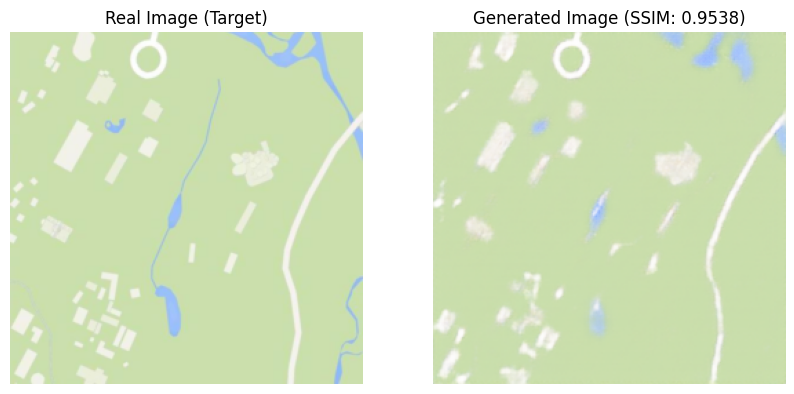

In [37]:
# Assuming you have the generator and validation loader
#netG.load_state_dict(torch.load('D:\\Datasets\\Detailed map from Aerial Images\\pix2pix_discriminator_2.pth'))

netG = torch.load('D:\\Datasets\\Detailed map from Aerial Images\\Trained Models\\pix2pix_generator_without_tuning.pt')
netG.eval()  # Set generator to evaluation mode

# List to store SSIM values
ssim_values_before_Tuning = []

# Variable to hold the last real and generated images
last_real_image = None
last_generated_image = None
last_ssim_value = None

# Loop through the validation/test dataset
with torch.no_grad():  # No need to compute gradients for evaluation
    for real_images, target_images in val_dataloader:
        
        # Move the images to the device (GPU or CPU)
        real_images = real_images.to(device)
        target_images = target_images.to(device)
        
        # Generate images using the trained generator
        generated_images = netG(real_images)
        
        # Convert tensors to NumPy arrays for SSIM calculation
        generated_images_np = generated_images.cpu().numpy()
        target_images_np = target_images.cpu().numpy()
        
        # Loop through the batch (assuming batch size = 1)
        for i in range(generated_images_np.shape[0]):
            # Get the target and generated images (remove the batch dimension)
            real_image = np.transpose(target_images_np[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
            generated_image = np.transpose(generated_images_np[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
            
            # Convert the images from [-1, 1] to [0, 255] range (assuming tanh output)
            real_image = ((real_image + 1) * 127.5).astype(np.uint8)
            generated_image = ((generated_image + 1) * 127.5).astype(np.uint8)

            # Calculate SSIM
            ssim_value = ssim(real_image, generated_image, multichannel=True, win_size=3)
            ssim_values_before_Tuning.append(ssim_value)
            
            # Update the last real and generated image (for display after the loop)
            last_real_image = real_image
            last_generated_image = generated_image
            last_ssim_value = ssim_value

# Calculate the average SSIM over the dataset
average_ssim = np.mean(ssim_values_before_Tuning)
print(f"Average SSIM: {average_ssim:.4f}")

# Separate display of the last real vs generated images
if last_real_image is not None and last_generated_image is not None:
    plt.figure(figsize=(10, 5))
    
    # Plot the real image
    plt.subplot(1, 2, 1)
    plt.imshow(last_real_image)
    plt.title("Real Image (Target)")
    plt.axis('off')

    # Plot the generated image
    plt.subplot(1, 2, 2)
    plt.imshow(last_generated_image)
    plt.title(f"Generated Image (SSIM: {last_ssim_value:.4f})")
    plt.axis('off')
    
    plt.show()


# Training and Testing With Tuning

Epoch [1/100] - Loss D: 0.1392, Loss G: 7.1684
Epoch [2/100] - Loss D: 0.0885, Loss G: 6.8599
Epoch [3/100] - Loss D: 0.0661, Loss G: 6.7878
Epoch [4/100] - Loss D: 0.0550, Loss G: 6.7455
Epoch [5/100] - Loss D: 0.0441, Loss G: 6.5572
Epoch [6/100] - Loss D: 0.0349, Loss G: 6.3773
Epoch [7/100] - Loss D: 0.0695, Loss G: 6.4156
Epoch [8/100] - Loss D: 0.1207, Loss G: 6.4364
Epoch [9/100] - Loss D: 0.1039, Loss G: 6.1581
Epoch [10/100] - Loss D: 0.1055, Loss G: 6.2020
Epoch [11/100] - Loss D: 0.0994, Loss G: 6.0401
Epoch [12/100] - Loss D: 0.1039, Loss G: 5.9195
Epoch [13/100] - Loss D: 0.1058, Loss G: 5.8288
Epoch [14/100] - Loss D: 0.1081, Loss G: 5.6055
Epoch [15/100] - Loss D: 0.1043, Loss G: 5.4309
Epoch [16/100] - Loss D: 0.1021, Loss G: 5.3053
Epoch [17/100] - Loss D: 0.1059, Loss G: 5.1610
Epoch [18/100] - Loss D: 0.1032, Loss G: 5.0521
Epoch [19/100] - Loss D: 0.1065, Loss G: 4.9489
Epoch [20/100] - Loss D: 0.1001, Loss G: 4.7936
Epoch [21/100] - Loss D: 0.1015, Loss G: 4.6534
E

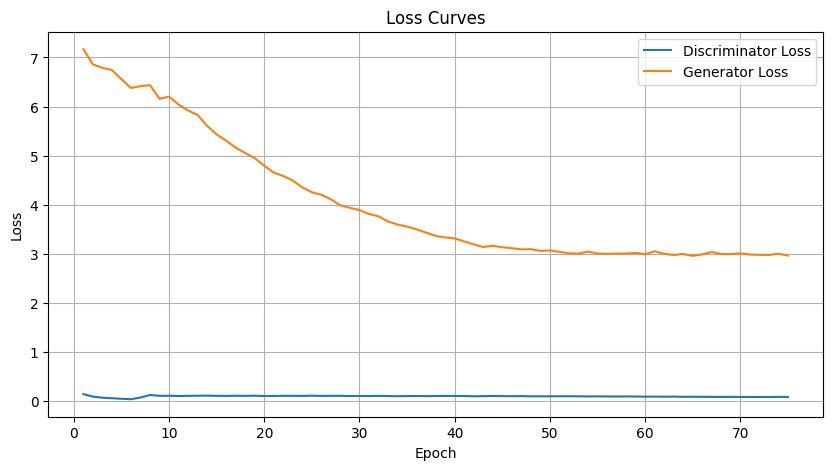

In [15]:
#Early stopping parameters
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

# Checkpointing and saving the best model
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filename)


loss_D_list = []
loss_G_list = []
# Add gradient clipping in training loop to prevent gradient explosion
def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# Modify the training loop with early stopping, checkpointing, and regularization
num_epochs = 100
for epoch in range(num_epochs):
    epoch_loss_D = 0.0
    epoch_loss_G = 0.0
    netG.train()
    netD.train()

    for satellite, target_map in train_dataloader:
        satellite, target_map = satellite.cuda(), target_map.cuda()
        batch_size = satellite.size(0)

        # Generate labels for real and fake images
        real_labels = torch.ones((batch_size, 1, 30, 30)).cuda()
        fake_labels = torch.zeros((batch_size, 1, 30, 30)).cuda()

        ### Train Discriminator ###
        optimizer_D.zero_grad()

        # Discriminator loss for real images
        real_predictions = netD(torch.cat((satellite, target_map), dim=1))
        real_predictions = torch.sigmoid(real_predictions)
        real_loss = criterion_GAN(real_predictions, real_labels)

        # Discriminator loss for fake images
        fake_maps = netG(satellite)
        fake_predictions = netD(torch.cat((satellite, fake_maps.detach()), dim=1))
        fake_loss = criterion_GAN(fake_predictions, fake_labels)

        # Combine real and fake losses
        loss_D = (real_loss + fake_loss) / 2
        loss_D.backward()
        
        # Clip gradients if needed
        clip_gradients(netD)

        optimizer_D.step()

        ### Train Generator ###
        optimizer_G.zero_grad()

        # GAN loss for the generator
        fake_predictions = netD(torch.cat((satellite, fake_maps), dim=1))
        loss_GAN = criterion_GAN(fake_predictions, real_labels)

        # L1 loss for pixel-level similarity
        loss_L1 = criterion_L1(fake_maps, target_map) * 100

        # Total generator loss
        loss_G = loss_GAN + loss_L1
        loss_G.backward()

        # Clip gradients if needed
        clip_gradients(netG)

        optimizer_G.step()

        # Accumulate losses for the epoch
        epoch_loss_D += loss_D.item()
        epoch_loss_G += loss_G.item()

    # Average loss for the epoch
    avg_loss_D = epoch_loss_D / len(dataloader)
    avg_loss_G = epoch_loss_G / len(dataloader)

    # Append losses for plotting
    loss_D_list.append(avg_loss_D)
    loss_G_list.append(avg_loss_G)

    # Early stopping logic
    if avg_loss_G < best_val_loss:
        best_val_loss = avg_loss_G
        epochs_without_improvement = 0
        save_checkpoint(netG, optimizer_G, epoch, avg_loss_G, filename="best_model.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print loss for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss D: {avg_loss_D:.4f}, Loss G: {avg_loss_G:.4f}")

# Save the trained models
torch.save(netG.state_dict(), 'D:\\Datasets\\Detailed map from Aerial Images\\pix2pix_generator_final.pt')
torch.save(netD.state_dict(), 'D:\\Datasets\\Detailed map from Aerial Images\\pix2pix_discriminator_final.pt')

# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_D_list) + 1), loss_D_list, label='Discriminator Loss')
plt.plot(range(1, len(loss_G_list) + 1), loss_G_list, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.savefig('training_loss_2.png')  # Save the loss plot
plt.show()


C:\Users\shafq\AppData\Local\Temp\ipykernel_11652\2938804926.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG = torch.load('D:\\Datasets\\Detailed map from Aerial Im

Average SSIM: 0.7755


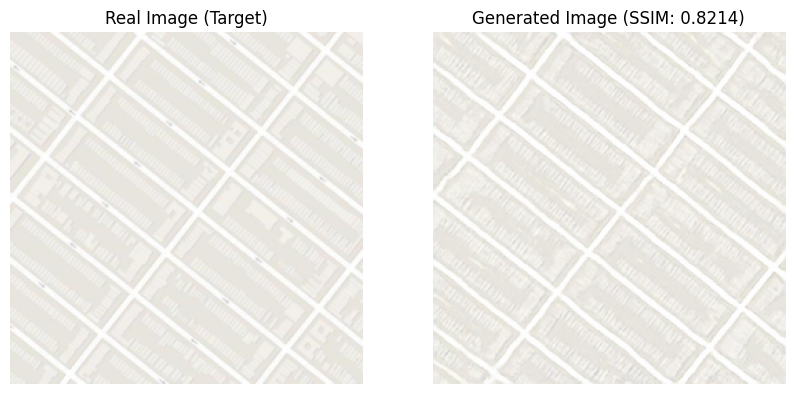

In [36]:
# Set generator to evaluation mode
netG = torch.load('D:\\Datasets\\Detailed map from Aerial Images\\Trained Models\\pix2pix_generator_final.pt')
netG.eval()

# List to store SSIM values and images
ssim_values_after_Tuning = []
all_real_images = []
all_generated_images = []

# Loop through the validation/test dataset
with torch.no_grad():  # No need to compute gradients for evaluation
    for real_images, target_images in val_dataloader:
        # Move the images to the device (GPU or CPU)
        real_images = real_images.to(device)
        target_images = target_images.to(device)

        # Generate images using the trained generator
        generated_images = netG(real_images)

        # Convert tensors to NumPy arrays for SSIM calculation
        generated_images_np = generated_images.cpu().numpy()
        target_images_np = target_images.cpu().numpy()

        # Loop through the batch
        for i in range(generated_images_np.shape[0]):
            # Get the target and generated images (remove the batch dimension)
            real_image = np.transpose(target_images_np[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
            generated_image = np.transpose(generated_images_np[i], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

            # Convert the images from [-1, 1] to [0, 255] range (assuming tanh output)
            real_image = ((real_image + 1) * 127.5).astype(np.uint8)
            generated_image = ((generated_image + 1) * 127.5).astype(np.uint8)

            # Calculate SSIM
            ssim_value = ssim(real_image, generated_image, multichannel=True, win_size=3)
            ssim_values_after_Tuning.append(ssim_value)

            # Store the images for later use
            all_real_images.append(real_image)
            all_generated_images.append(generated_image)

# Calculate the average SSIM over the dataset
average_ssim = np.mean(ssim_values_after_Tuning)
print(f"Average SSIM: {average_ssim:.4f}")

# Randomly select an image pair for display
random_index = random.randint(0, len(all_real_images) - 1)
random_real_image = all_real_images[random_index]
random_generated_image = all_generated_images[random_index]
random_ssim_value = ssim_values[random_index]

# Display the randomly selected real and generated image pair
plt.figure(figsize=(10, 5))

# Plot the real image
plt.subplot(1, 2, 1)
plt.imshow(random_real_image)
plt.title("Real Image (Target)")
plt.axis('off')

# Plot the generated image
plt.subplot(1, 2, 2)
plt.imshow(random_generated_image)
plt.title(f"Generated Image (SSIM: {random_ssim_value:.4f})")
plt.axis('off')

plt.show()

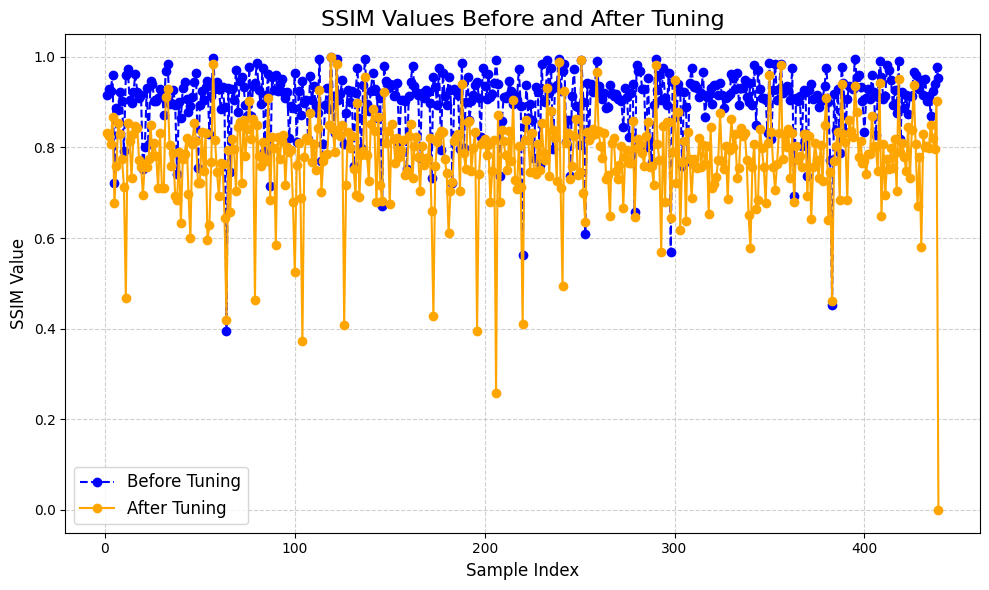

In [40]:
# Create indices for the x-axis (e.g., sample indices)
samples = range(1, len(ssim_values_after_Tuning) + 1)

# Plot SSIM values
plt.figure(figsize=(10, 6))
plt.plot(samples, ssim_values_before_Tuning, label="Before Tuning", marker='o', linestyle='--', color='blue')
plt.plot(samples, ssim_values_after_Tuning, label="After Tuning", marker='o', linestyle='-', color='orange')

# Add titles and labels
plt.title("SSIM Values Before and After Tuning", fontsize=16)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("SSIM Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

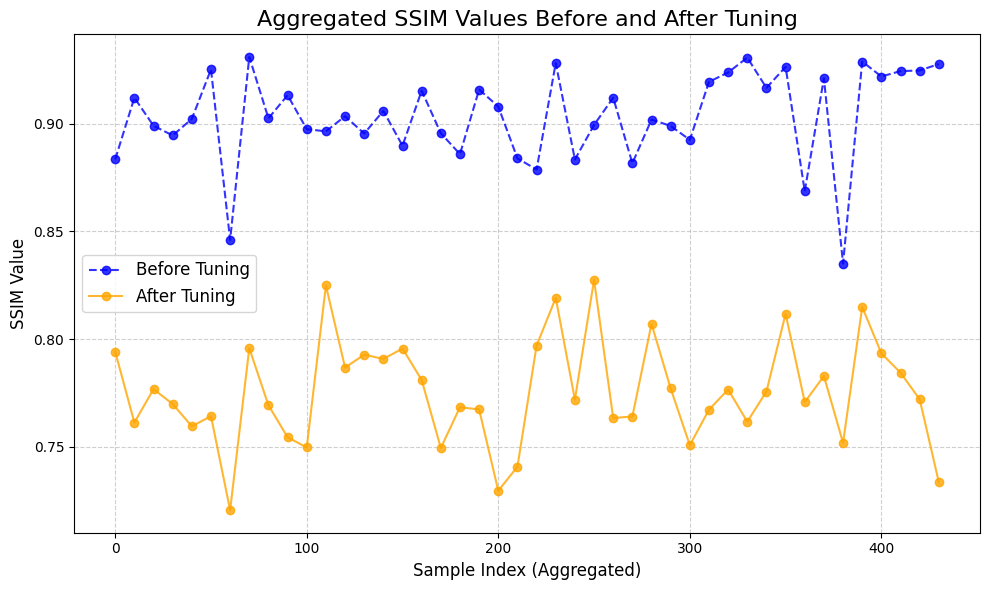

In [41]:
# Define an interval to aggregate SSIM values (e.g., average every 10 samples)
interval = 10
aggregated_samples = np.arange(0, len(ssim_values_before_Tuning), interval)
avg_ssim_before = [np.mean(ssim_values_before_Tuning[i:i + interval]) for i in aggregated_samples]
avg_ssim_after = [np.mean(ssim_values_after_Tuning[i:i + interval]) for i in aggregated_samples]

# Plot SSIM values
plt.figure(figsize=(10, 6))
plt.plot(aggregated_samples, avg_ssim_before, label="Before Tuning", marker='o', linestyle='--', color='blue', alpha=0.8)
plt.plot(aggregated_samples, avg_ssim_after, label="After Tuning", marker='o', linestyle='-', color='orange', alpha=0.8)

# Add titles and labels
plt.title("Aggregated SSIM Values Before and After Tuning", fontsize=16)
plt.xlabel("Sample Index (Aggregated)", fontsize=12)
plt.ylabel("SSIM Value", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()
